# **CSE655 Homework 2**

## **Part I: Digit Recognition Using CNNs**

In [47]:
# Imports
import random
import math
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.datasets import mnist

In [ ]:
# Load the MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Normalization
x_train = x_train / 255.0
x_test = x_test / 255.0

print("Train Size : ", len(x_train))
print("Test Size : ", len(x_test))
print("Input Shape :", len(x_train[0][0]), "x", len(x_train[0]))

Train Size :  60000
Test Size :  10000
Input Shape : 28 x 28


In [9]:
# Model
model = models.Sequential([
    layers.Input(shape=(28, 28)),
    layers.Reshape((28, 28, 1)), 
    layers.Conv2D(24, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(36, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(10, activation='softmax')
])

# Compile
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Train
model.fit(x_train, y_train, epochs=5)

Epoch 1/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.8942 - loss: 0.3427
Epoch 2/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.9828 - loss: 0.0535
Epoch 3/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.9892 - loss: 0.0352
Epoch 4/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.9918 - loss: 0.0269
Epoch 5/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.9938 - loss: 0.0210


In [10]:
# Evaluation
test_loss, test_acc = model.evaluate(x_test, y_test)
print(f"Test Accuracy: {test_acc}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9835 - loss: 0.0466
Test Accuracy: 0.9882000088691711


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


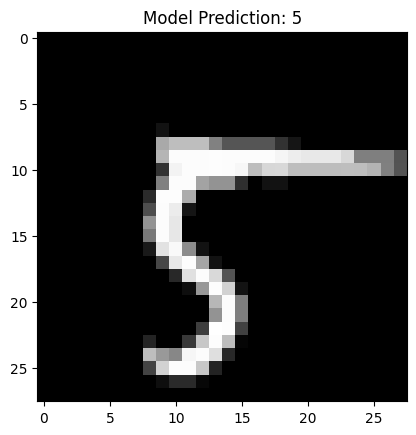

In [22]:
# Select a random index
xrand = random.randint(0, len(x_test) - 1)
xn = x_test[xrand].reshape(1, 28, 28, 1)  # Add batch dimension for prediction
predicted = model.predict(xn)

# Display the image
plt.imshow(x_test[xrand], cmap='gray')
plt.title(f"Model Prediction: {predicted.argmax()}")
plt.show()


## **Conclusion**

The training and prediction time for a model with 28x28 input is considerably short. Using 60,000 images from the MNIST dataset for training, this brief process achieved an accuracy of 98.8%. Model layers : (Conv2D : 3x3 relu)(24) -> (PoolMax : 2x2) -> (Conv2D : 3x3 relu)(36) -> (PoolMax : 2x2) -> (Conv2D : 3x3 relu)(64) -> (Flatten) -> (Dense relu)(64) -> (Dense softmax)(10)

## **Part 2: Input Optimization For a CNN**

### **2.1 Random Noise Image Optimization**

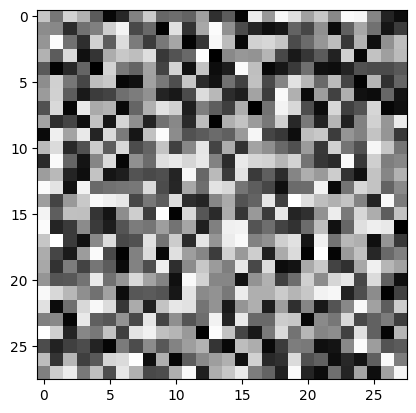

In [263]:
# a. Create a random image (your image should be gray scale with values from 0 to 1, i.e.,normalized).

random_image = np.random.random((28, 28))
plt.imshow(random_image, cmap='gray')
plt.show()

In [264]:
# b. Feed the random image to the model.

predicted = model.predict(random_image.reshape(1, 28, 28, 1)) # Reshaping for batch dimension 
print("Prediction :",predicted)
num = predicted.argmax()
print(f"It looks like: ({num}) with {int(predicted[0][num]*100)}% confidence")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction : [[0.03373493 0.04605521 0.08104288 0.03338206 0.07752568 0.11005209
  0.071589   0.04999261 0.45826405 0.03836146]]
It looks like: (8) with 45% confidence


I don't understand why but my model says "8" to all random images with some confidency.

In [ ]:
# c. Try to minimize the error in the output by continuously updating the input image using
#    gradient descent.  For this you need to write  a proper loss function  along with some
#    constraints  for regularization (image pixel values to stay within the interval [0,1]).

# example target : [0, 0, 0, 1, 0, 0, 0, 0, 0, 0] # example prediction : [0.04330017, 0.05467458, 0.04155311, 0.0276827, 0.0635523, 0.08241461, 0.05750921, 0.05449867, 0.546441, 0.02837372]
def crossEntropyLoss(target, prediction):
    epsilon = 1e-15 
    loss = -tf.reduce_sum(target * tf.math.log(prediction + epsilon)) 
    return loss

In [280]:
def inputOptimizer(model, image, target, loss_func, learning_rate=0.1, steps=10):
    img = tf.Variable(image, dtype=tf.float32)

    # Adam optimizer
    optimizer = tf.keras.optimizers.Adam(learning_rate = learning_rate)

    for step in range(steps):
        with tf.GradientTape() as tape:
            tape.watch(img)
            
            # Prediction
            reshaped_image = tf.reshape(img, (1, 28, 28, 1))
            prediction = model(reshaped_image)[0]  

            # Calculate the loss according to given loss function
            loss = loss_func(target, prediction)

        # Calculate the gradients
        gradients = tape.gradient(loss, [img])
        optimizer.apply_gradients(zip(gradients, [img]))  # Update the image with gradient vectors

        # Print step update
        print(f"Step {step}, Loss: {loss}")

    # Return optimized Image
    return img.numpy() 


Step 0, Loss: 3.0599923133850098
Step 0, Loss: 3.0599923133850098
Step 1, Loss: 1.0146228075027466
Step 0, Loss: 3.0599923133850098
Step 1, Loss: 1.0146228075027466
Step 2, Loss: 0.1466030478477478
Step 0, Loss: 3.0599923133850098
Step 1, Loss: 1.0146228075027466
Step 2, Loss: 0.1466030478477478
Step 3, Loss: 0.02326630987226963
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


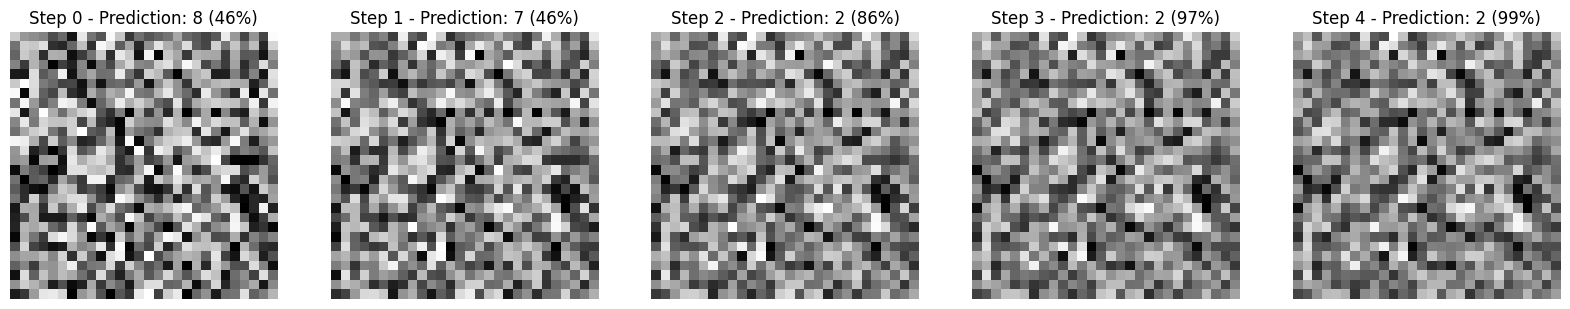

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
It looks like: (2) with 99% confidence


In [281]:
# d. Report the best image found for this. Try this for a few iterations of the random image
#    to see how the optimization is affected by the initial choice of the image.

# Optimize the "random_image" input for "2"
target_class = 2
target = np.zeros(10)
target[target_class] = 1 #[0, 0, 1, 0, 0, 0, 0, 0, 0, 0]
optimized_images = []

for i in range(5):
    optimized_image = inputOptimizer(model, random_image, target, crossEntropyLoss, steps=i)
    optimized_images.append(optimized_image)  

fig, axes = plt.subplots(1, 5, figsize=(20, 5))

for i, optimized_image in enumerate(optimized_images):
    axes[i].imshow(optimized_image, cmap='gray') 
    predicted = model.predict(optimized_image.reshape(1, 28, 28, 1)) 
    num = predicted.argmax()
    confidence = int(predicted[0][num] * 100)
    axes[i].set_title(f"Step {i} - Prediction: {num} ({confidence}%)")
    axes[i].axis('off')  

plt.show()  

final_optimized_image = optimized_images[-1]
predicted = model.predict(final_optimized_image.reshape(1, 28, 28, 1))
num = predicted.argmax()
print(f"It looks like: ({num}) with {int(predicted[0][num] * 100)}% confidence")

### **2.2 Model Manipulation**
We can use inputOptimize fuction for manipulating the model for target output. This function forces the model for give wrong outputs. 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


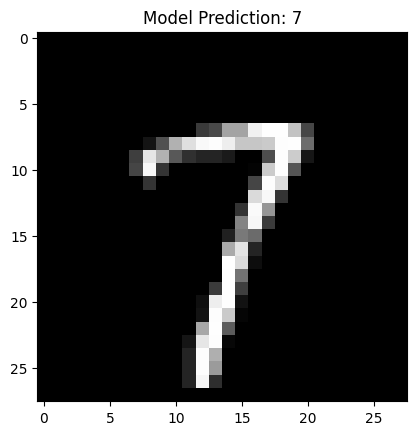

It looks like: (7) with 99% confidence


In [287]:
mnist_image = x_test[random.randint(0,len(x_test))]
predicted = model.predict(mnist_image.reshape(1, 28, 28, 1))

plt.imshow(mnist_image, cmap='gray')
plt.title(f"Model Prediction: {predicted.argmax()}")
plt.show()
num = predicted.argmax()
print(f"It looks like: ({num}) with {int(predicted[0][num]*100)}% confidence")

Step 0, Loss: 8.773815155029297
Step 0, Loss: 8.773815155029297
Step 1, Loss: 1.1729098558425903
Step 0, Loss: 8.773815155029297
Step 1, Loss: 1.1729098558425903
Step 2, Loss: 0.04464644193649292
Step 0, Loss: 8.773815155029297
Step 1, Loss: 1.1729098558425903
Step 2, Loss: 0.04464644193649292
Step 3, Loss: 0.014239239506423473
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


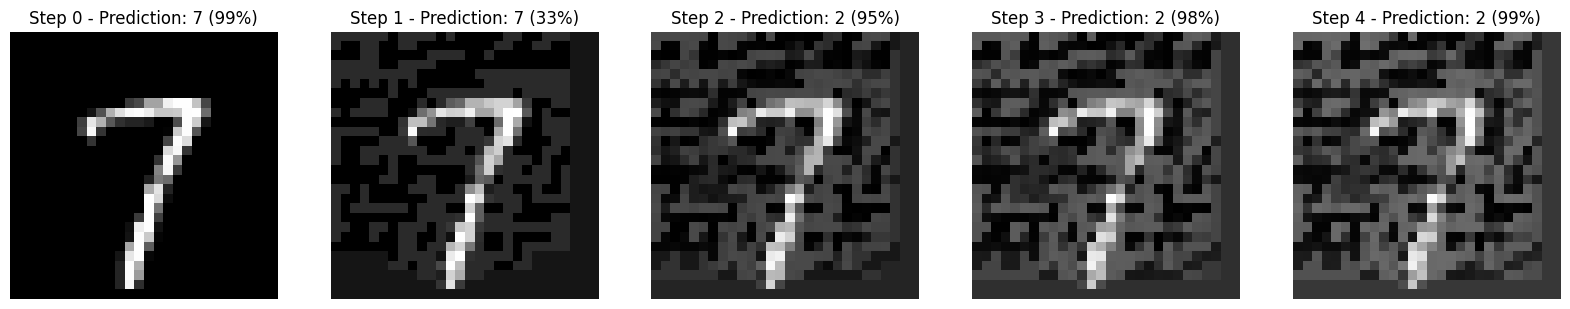

In [288]:
# Manipulate the "7" image for "2" model output
target_class = 2

target = np.zeros(10)
target[target_class] = 1 #[0, 0, 1, 0, 0, 0, 0, 0, 0, 0]
manipulated_images = []

for i in range(5):
    manipulated_image = inputOptimizer(model, mnist_image, target, crossEntropyLoss, steps=i)
    manipulated_images.append(manipulated_image)  

fig, axes = plt.subplots(1, 5, figsize=(20, 5))

for i, manipulated_image in enumerate(manipulated_images):
    axes[i].imshow(manipulated_image, cmap='gray') 
    predicted = model.predict(manipulated_image.reshape(1, 28, 28, 1)) 
    num = predicted.argmax()
    confidence = int(predicted[0][num] * 100)
    axes[i].set_title(f"Step {i} - Prediction: {num} ({confidence}%)")
    axes[i].axis('off')  

plt.show()

### **2.3 Low Confidence Output**
* a. All the other digits. For example, for 8 your output is [0,0,0,0,0,0,0,0,1,0].
* b. Set the output to [0,0,0.5,0.5,0,0,0,0,0,0] meaning something between digits 2 and 3.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


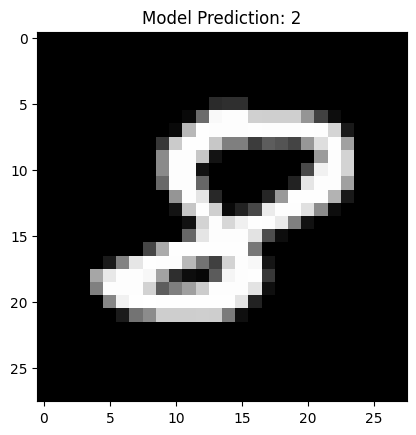

It looks like: (2) with 99% confidence


In [ ]:
mnist_image = x_test[61]
predicted = model.predict(manipulated_image.reshape(1,28,28,1))
num = predicted.argmax()
plt.imshow(mnist_image, cmap='gray')
plt.title(f"Model Prediction: {num}")
plt.show()
print(f"It looks like: ({num}) with {int(predicted[0][num]*100)}% confidence")

Step 0, Loss: 15.60045051574707
Step 0, Loss: 15.60045051574707
Step 1, Loss: 5.491788864135742
Step 0, Loss: 15.60045051574707
Step 1, Loss: 5.491788864135742
Step 2, Loss: 0.8494601249694824
Step 0, Loss: 15.60045051574707
Step 1, Loss: 5.491788864135742
Step 2, Loss: 0.8494601249694824
Step 3, Loss: 0.7247705459594727
Step 0, Loss: 15.60045051574707
Step 1, Loss: 5.491788864135742
Step 2, Loss: 0.8494601249694824
Step 3, Loss: 0.7247705459594727
Step 4, Loss: 0.7397310733795166
Step 0, Loss: 15.60045051574707
Step 1, Loss: 5.491788864135742
Step 2, Loss: 0.8494601249694824
Step 3, Loss: 0.7247705459594727
Step 4, Loss: 0.7397310733795166
Step 5, Loss: 0.9661492109298706
Step 0, Loss: 15.60045051574707
Step 1, Loss: 5.491788864135742
Step 2, Loss: 0.8494601249694824
Step 3, Loss: 0.7247705459594727
Step 4, Loss: 0.7397310733795166
Step 5, Loss: 0.9661492109298706
Step 6, Loss: 0.9981545805931091
Step 0, Loss: 15.60045051574707
Step 1, Loss: 5.491788864135742
Step 2, Loss: 0.849460124

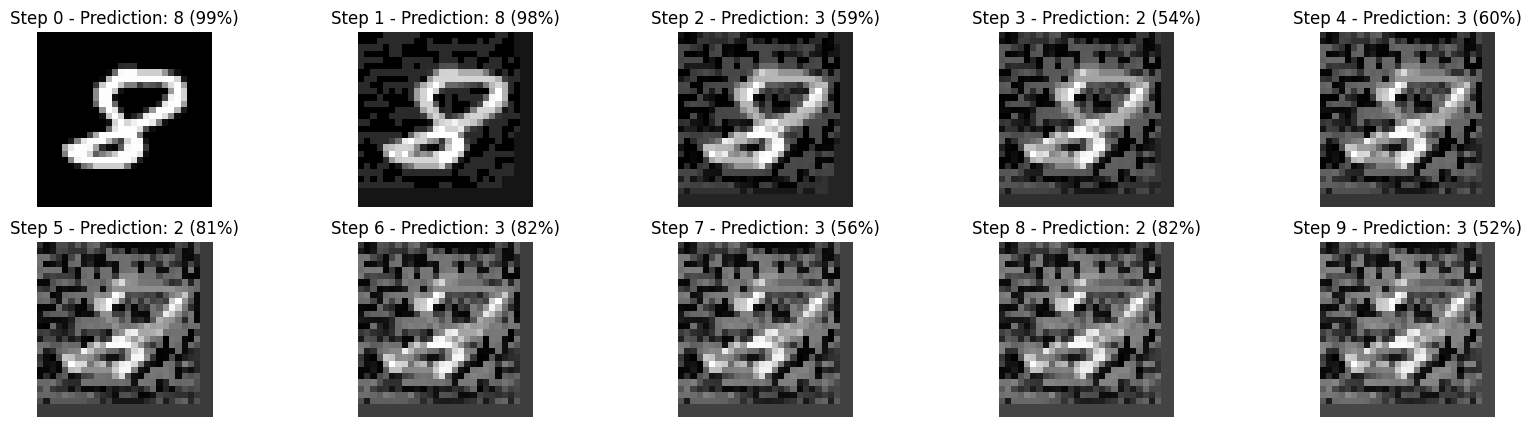

In [367]:
target = [0,0,0.5,0.5,0,0,0,0,0,0]

manipulated_images = []
for i in range(10):
    manipulated_image = inputOptimizer(model, mnist_image, target, crossEntropyLoss, steps=i)
    manipulated_images.append(manipulated_image)  

fig, axes = plt.subplots(2, 5, figsize=(20, 5))

for i, manipulated_image in enumerate(manipulated_images):
    axes[i // 5, i % 5].imshow(manipulated_image, cmap='gray')  # Görseli yerleştir
    predicted = model.predict(manipulated_image.reshape(1, 28, 28, 1))  # Tahmin yap
    num = predicted.argmax()  # Tahmin edilen sınıf
    confidence = int(predicted[0][num] * 100)  # Güven oranı
    axes[i // 5, i % 5].set_title(f"Step {i} - Prediction: {num} ({confidence}%)")  # Başlık ekle
    axes[i // 5, i % 5].axis('off')  # Eksenleri kaldır

plt.show()

In [ ]:
predicted = model.predict(manipulated_images[9].reshape(1, 28, 28, 1))
print(np.round(predicted, 2))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
[[0.   0.   0.37 0.61 0.   0.01 0.   0.   0.   0.  ]]
